In [82]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
DEFAULT_TEMPLATE_MATCHING_THRESHOLD = 0.5

In [3]:
class Template:
    def __init__(
        self,
        image_path,
        label,
        color,
        matching_threshold=DEFAULT_TEMPLATE_MATCHING_THRESHOLD
    ):
        self.image_path = image_path
        self.label = label
        self.color = color
        self.template = cv2.imread(image_path)
        self.template_height, self.template_width = self.template.shape[:2]
        self.matching_threshold = matching_threshold

In [16]:
FILE = 'test.png'

In [17]:
image = cv2.imread(FILE)
templates = [
    Template(image_path="d.png", label="d", color=(0, 0, 255))
]

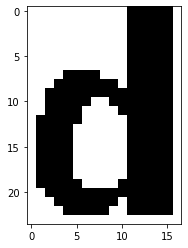

In [83]:
plt.imshow(templates[0].template)

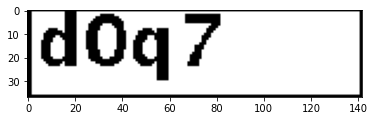

In [84]:
plt.imshow(image)

In [41]:
detections = []
for template in templates:
    template_matching = cv2.matchTemplate(
        template.template, image, cv2.TM_CCOEFF_NORMED
    )
    match_locations = np.where(template_matching >= template.matching_threshold)
    for (x, y) in zip(match_locations[1], match_locations[0]):
        match = {
            "TOP_LEFT_X": x,
            "TOP_LEFT_Y": y,
            "BOTTOM_RIGHT_X": x + template.template_width,
            "BOTTOM_RIGHT_Y": y + template.template_height,
            "MATCH_VALUE": template_matching[y, x],
            "LABEL": template.label,
            "COLOR": template.color
        }
        
        detections.append(match)

In [65]:
image_with_detections = image.copy()
for detection in detections:
    cv2.rectangle(
        image_with_detections,
        (detection["TOP_LEFT_X"], detection["TOP_LEFT_Y"]),
        (detection["BOTTOM_RIGHT_X"], detection["BOTTOM_RIGHT_Y"]),
        detection["COLOR"],
        2
    )
    #cv2.putText(
    #    image_with_detections,
    #    f"{detection['LABEL']} - {detection['MATCH_VALUE']}",
    #    (detection["TOP_LEFT_X"] + 2, detection["TOP_LEFT_Y"] + 20),
    #    cv2.FONT_HERSHEY_SIMPLEX,
    #    0.5,
    #    detection["COLOR"],
    #    1,
    #    cv2.LINE_AA
    #)

In [66]:
detections

[{'TOP_LEFT_X': 4,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 21,
  'BOTTOM_RIGHT_Y': 24,
  'MATCH_VALUE': 0.50685394,
  'LABEL': 'd',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 5,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 22,
  'BOTTOM_RIGHT_Y': 24,
  'MATCH_VALUE': 0.7625467,
  'LABEL': 'd',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 6,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 23,
  'BOTTOM_RIGHT_Y': 24,
  'MATCH_VALUE': 0.5068539,
  'LABEL': 'd',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 44,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 61,
  'BOTTOM_RIGHT_Y': 24,
  'MATCH_VALUE': 0.5950329,
  'LABEL': 'd',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 4,
  'TOP_LEFT_Y': 1,
  'BOTTOM_RIGHT_X': 21,
  'BOTTOM_RIGHT_Y': 25,
  'MATCH_VALUE': 0.6372464,
  'LABEL': 'd',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 5,
  'TOP_LEFT_Y': 1,
  'BOTTOM_RIGHT_X': 22,
  'BOTTOM_RIGHT_Y': 25,
  'MATCH_VALUE': 1.0,
  'LABEL': 'd',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 6,
  'TOP_LEFT_Y': 1,
  'BOTTOM_RIGHT_X': 23,
  'BOTTOM_RI

In [67]:
cv2.imwrite("result.jpeg", image_with_detections)

True

In [68]:
def compute_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [74]:
def non_max_suppression(
    objects,
    non_max_suppression_threshold=0.5,
    score_key="MATCH_VALUE"
):
    sorted_objects = sorted(objects, key=lambda obj: obj[score_key], reverse=True)
    #print(sorted_objects)
    filtered_objects = []
    for i1, object_ in enumerate(sorted_objects):
        overlap_found = False
        for i2, filtered_object in enumerate(sorted_objects):
            # if i1 != i2:
            box_object = [object_['TOP_LEFT_Y'], object_['TOP_LEFT_X'], object_['BOTTOM_RIGHT_Y'], object_['BOTTOM_RIGHT_X']]
            box_filtered = [filtered_object['TOP_LEFT_Y'], filtered_object['TOP_LEFT_X'], filtered_object['BOTTOM_RIGHT_Y'], filtered_object['BOTTOM_RIGHT_X']]
            iou = compute_iou(box_object, box_filtered)
            print(iou)
            if iou > non_max_suppression_threshold:
                overlap_found = True
                break
            if not overlap_found:
                filtered_objects.append(object_)
    return filtered_objects

In [75]:
NMS_THRESHOLD = 0.2
detections_ = non_max_suppression(detections, non_max_suppression_threshold=NMS_THRESHOLD)

0.9999999754901967
0.9199999783529418
0.0
0.0
0.9999999754901967
0.9199999783529418
0.0
0.0
0.9199999783529418
0.8461538270100945
0.8888888683127577
0.8888888683127577
0.0
0.0
0.9199999783529418
0.8214285530931127
0.8214285530931127
0.0
0.0
0.8888888683127577
0.0
0.0
0.8461538270100945
0.8214285530931127
0.8214285530931127


In [86]:
detections_ = sorted(detections, key=lambda obj: obj['MATCH_VALUE'], reverse=True)

In [87]:
image_with_detections = image.copy()
for detection in detections_[:1]:
    cv2.rectangle(
        image_with_detections,
        (detection["TOP_LEFT_X"], detection["TOP_LEFT_Y"]),
        (detection["BOTTOM_RIGHT_X"], detection["BOTTOM_RIGHT_Y"]),
        detection["COLOR"],
        2
    )
    #cv2.putText(
    #    image_with_detections,
    #    f"{detection['LABEL']} - {detection['MATCH_VALUE']}",
    #    (detection["TOP_LEFT_X"] + 2, detection["TOP_LEFT_Y"] + 20),
    #    cv2.FONT_HERSHEY_SIMPLEX,
    #    0.5,
    #    detection["COLOR"],
    #    1,
    #    cv2.LINE_AA
    #)

In [88]:
cv2.imwrite("result_2.jpeg", image_with_detections)

True